**DOMAIN**: Health Care

**CONTEXT**:
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation
of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical
images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

**DATA DESCRIPTION**:
- In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was
determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the
appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original link to the dataset : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data [ for your reference
only ]. You can refer to the details of the dataset in the above link
- Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.

**PROJECT OBJECTIVE**: Design a DL based algorithm for detecting pneumonia.


**Milestone 1**

**importing important libs**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import keras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import pickle


import csv
import random
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input,GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalMaxPooling2D

!pip install pydicom
import pydicom as dcm
from pydicom.pixel_data_handlers.util import apply_voi_lut

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.0 MB/s eta 0:00:00


In [ ]:
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser 
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=cwhkrc2g1A2phqi%2FZiCt9EwDeqb-JDkJSCX5GeWKOFs'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/bin/sh: 1: open: not found
Cannot retrieve auth tokens.
Failure("Error opening URL:https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.

**Step 1: Import the data. [ 3 points ]**

In [ ]:
train_labels = pd.read_csv("/content/gdrive/My Drive/cv capstone/stage_2_train_labels.csv") 
print(train_labels.shape)
print(train_labels.head())
detailed_class_info = pd.read_csv("/content/gdrive/My Drive/cv capstone/stage_2_detailed_class_info.csv")
print(detailed_class_info.shape)
print(detailed_class_info.head())

(30227, 6)
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
(30227, 2)
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


In [ ]:
detailed_class_info.isna().sum()
len(detailed_class_info['patientId'].unique())

26684

In [ ]:
train_labels.isna().sum()
len(train_labels['patientId'].unique())

26684

In [ ]:
print('Total number of null values in bounding boxes columns(x, y, width, height): {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Total value counts for the Target column: {}'.format(train_labels['Target'].value_counts().to_dict()))

Total number of null values in bounding boxes columns(x, y, width, height): {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Total value counts for the Target column: {0: 20672, 1: 9555}


**Observation:** Total number of null values in bounding boxes columns is equal to total number of 0s in Target column.

In [ ]:
#Analysing the labels dataframe
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
#Checking for unique patient records ==total number of patients
train_labels.patientId.nunique()

26684

In [ ]:
train_labels["patientId"].count()-train_labels.patientId.nunique()

3543

**Observation:** From the above data, we can notice that there are around 30227 rows in stage_2_train_labels.csv but we have a total of 26684 unique patientIDs. Hence 3543 patients have more than one bounding box. Verifying this for a patient with the patientId: 00436515-870c-4b36-a041-de91049b9ab4 is the same from 4th and 5th rows of the dataframe.

In [ ]:
train_labels[train_labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

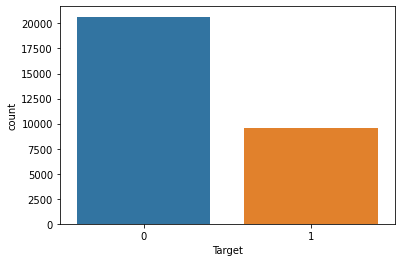

In [ ]:
sns.countplot(x='Target',data=train_labels);

In [ ]:
detailed_class_info.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

**Observation:** There are 3 different class values - Normal,Lung Opacity and No Lung Opacity/Not Normal.

In [ ]:
detailed_class_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
detailed_class_info.describe()

patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     3239951b-6211-4290-b237-3d9ad17176db  No Lung Opacity / Not Normal
freq                                       4                         11821

In [ ]:
#Checking for duplicate values
detailed_class_info[detailed_class_info.duplicated()].shape

(3543, 2)

**Observation:** The total number of patients match with the value from training labels which is 26684. 

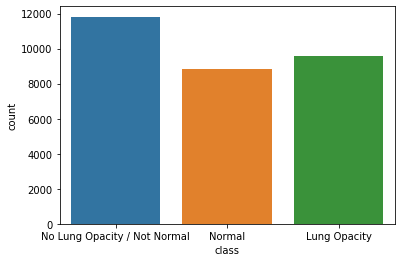

In [ ]:
#Checking the class values distribution
sns.countplot(x='class',data=detailed_class_info);

**Observation:**  From the countplot, it is very much noticeable that all the classes are almost equally distributed. We can further check for duplicate and missing values as well

In [ ]:
#Checking for missing values
detailed_class_info.isnull().sum()

patientId    0
class        0
dtype: int64

**Observation:** There are no missing values in the class info data

**Step 2: Map training and testing images to its classes. [ 4 points ]**

In [ ]:
# Conctinating the two dataset - 'train_labels' and 'detailed_class_info':
train = pd.concat([train_labels,detailed_class_info['class']], axis = 1)

train.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [ ]:
print(train.isna().sum())
print(len(train['patientId'].unique()))

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64
26684


In [ ]:
print(train[train['Target'] == 0].isna().sum())

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64


In [ ]:
print(train[train['class'] == 'Normal'].isna().sum())
print(train[train['class'] == 'No Lung Opacity / Not Normal'].isna().sum())
print(train[train['class'] == 'Lung Opacity'].isna().sum())

patientId       0
x            8851
y            8851
width        8851
height       8851
Target          0
class           0
dtype: int64
patientId        0
x            11821
y            11821
width        11821
height       11821
Target           0
class            0
dtype: int64
patientId    0
x            0
y            0
width        0
height       0
Target       0
class        0
dtype: int64


In [ ]:
train[['x', 'y', 'width', 'height']].isnull().sum().to_dict()

{'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}

**Observation:** Total number of null values for "Normal" and "No Lung Opacity / Not Normal" is equal to total number of 0s in Target column i.e., who do not have pnemonia have their bounding box columns as NaN

**Step 3: Map training and testing images to its annotations [ 4 points ]**

In [ ]:
dcm_image_data = dcm.read_file('/content/gdrive/My Drive/cv capstone/stage_2_train_images/c1edf42b-5958-47ff-a1e7-4f23d99583ba.dcm')
print(dcm_image_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.22672.1517874443.53337
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.22672.1517874443.53337
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

**Observation**
1.   Images are stored in DICOM(Digital Imaging and Communications in Medicine) format with .dcm extension. This DICOM image contains more information like patient age, sex, modality, view position and body part and so on. 
2.   pydicom library is used to rread images



In [ ]:
dcm_image_data  = dcm.dcmread('/content/gdrive/My Drive/cv capstone/stage_2_train_images/c1edf42b-5958-47ff-a1e7-4f23d99583ba.dcm').pixel_array
dcm_image_data .shape

(1024, 1024)

**Observation:** Dimension of images are 1024x1024. It is very large to process so we will reduce it during model training.

In [ ]:
columns = ['Modality', 'Age', 'Sex']
train_path = os.listdir('/content/gdrive/My Drive/cv capstone/stage_2_train_images/')
class_metadata = train
for col in columns:
    class_metadata[col] = None
for index,file_name in enumerate(train_path):
    print('processing:',index,file_name)
    image_data = dcm.read_file('/content/gdrive/My Drive/cv capstone/stage_2_train_images/'+file_name)
    patient_id = (class_metadata['patientId']==image_data.PatientID)
    class_metadata.loc[patient_id,'Modality'] = image_data.Modality
    class_metadata.loc[patient_id,'PatientAge'] = pd.to_numeric(image_data.PatientAge)
    class_metadata.loc[patient_id,'PatientSex'] = image_data.PatientSex
    class_metadata.loc[patient_id,'ViewPosition'] = image_data.ViewPosition
    class_metadata.loc[patient_id,'BodyPartExamined'] = image_data.BodyPartExamined

Streaming output truncated to the last 5000 lines.
processing: 21684 45ddbd0e-006a-41c0-a32a-62a4cbeb2a13.dcm
processing: 21685 45dddc96-f7e8-4dcf-94b1-34349c0ffdc2.dcm
processing: 21686 46c93b1a-d220-4d35-a546-13151f5c2326.dcm
processing: 21687 461315f1-e601-45cd-8350-7952ff4833ef.dcm
processing: 21688 45c19b16-ce15-4312-b9fb-df6b80439474.dcm
processing: 21689 46026bf0-0b28-4cac-be7c-bf4f7f3d7b34.dcm
processing: 21690 46e2e0d2-a90e-43b3-82d4-885fd58c55ac.dcm
processing: 21691 45e259c3-c0e8-4d00-a6c8-f976328372ea.dcm
processing: 21692 46d39cb8-d15e-4d00-8c38-63bda0e28a9f.dcm
processing: 21693 4623b8aa-c30b-47e8-baae-cd5f1565fcb2.dcm
processing: 21694 45d15998-f751-4985-9d18-23be09274cf6.dcm
processing: 21695 46cc86e8-f8ba-4567-9285-cd70cd10bf24.dcm
processing: 21696 45e18056-b7eb-4477-8eeb-7b740b61e093.dcm
processing: 21697 462ccf28-7555-44f0-8d76-176de69d4c06.dcm
processing: 21698 466d72f0-5338-48c0-8302-3e9fec405856.dcm
processing: 21699 464a8cdb-4e55-48de-b61f-72edb6992e0f.dcm
proce

In [ ]:
class_metadata.BodyPartExamined.value_counts()

CHEST    30227
Name: BodyPartExamined, dtype: int64

In [ ]:
class_metadata.Modality.value_counts()

CR    30227
Name: Modality, dtype: int64

**Observation:**


*   "BodyPartExamined" is CHEST which is expected
*   "Modality" is CR (Computer Radiography)

In [ ]:
class_metadata.drop(['Age', 'Sex', 'BodyPartExamined'], axis=1,inplace =True)
class_metadata.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality  PatientAge PatientSex ViewPosition  
0  No Lung Opacity / Not Normal       CR        51.0          F           PA  
1  No Lung Opacity / Not Normal       CR        48.0          F           PA  
2  No Lung Opacity / Not Normal       CR        19.0          M           AP  
3                        Normal       CR        28.0          M           PA  
4                  Lung Opacity       CR        32.0          F           AP

In [ ]:
picklefile = open('/content/gdrive/My Drive/cv capstone/train1', 'wb')
pickle.dump(class_metadata, picklefile)
picklefile.close()

In [ ]:
picklefile = open('/content/gdrive/My Drive/cv capstone/train1', 'rb')
training_data= pickle.load(picklefile)
picklefile.close()

In [ ]:
 #Converting age to Numeric as the current data type is a String
training_data['PatientAge'] = training_data.PatientAge.astype(int)

In [ ]:
filepaths=[]
source_dir='/content/gdrive/My Drive/cv capstone/stage_2_train_images/'


In [ ]:
for f in training_data['patientId']:
    fpath=os.path.join(source_dir,f)
    filepaths.append(fpath)

In [ ]:
training_data['path']=filepaths

In [ ]:
training_data.sample(5)

patientId      x      y  width  height  \
16561  a008f7a9-38ba-4ea8-aa6c-3337dff354d6    NaN    NaN    NaN     NaN   
10351  6e71c881-b814-457f-8d31-00bda463396e    NaN    NaN    NaN     NaN   
16806  a1f31712-6665-443c-b0f9-4fe206e16fb2    NaN    NaN    NaN     NaN   
23580  d4683e9b-ee14-40e1-a9f9-1eebd8d125ee  285.0  301.0  226.0   412.0   
16480  9f65dff1-52fc-4d14-b918-a931ce1f91aa    NaN    NaN    NaN     NaN   

       Target                         class Modality  PatientAge PatientSex  \
16561       0  No Lung Opacity / Not Normal       CR          63          M   
10351       0  No Lung Opacity / Not Normal       CR          69          M   
16806       0                        Normal       CR          36          F   
23580       1                  Lung Opacity       CR          68          F   
16480       0                        Normal       CR          47          F   

      ViewPosition                                               path  
16561           PA  /content/gdrive/My Drive/cv capstone/stage_2_t...  
10351           AP  /content/gdrive/My Drive/cv capstone/stage_2_t...  
16806           PA  /content/gdrive/My Drive/cv capstone/stage_2_t...  
23580           AP  /content/gdrive/My Drive/cv capstone/stage_2_t...  
16480           PA  /content/gdrive/My Drive/cv capstone/stage_2_t...

In [ ]:
import matplotlib.patches as patches
def MapImagesToAnnotations(pid): # mapping images and annotations
  data = list(training_data[training_data['patientId']==pid].T.to_dict().values())
  for i,dr in enumerate(data):
    patientImage =dr['patientId']
    target=dr['Target']
    cls =dr['class']   
    f, ax = plt.subplots()
    id =dr['path']+'.dcm'
    pic = dcm.read_file(id, force =True)
    modality = pic.Modality
    age = pic.PatientAge
    sex = pic.PatientSex
    bodyPart = pic.BodyPartExamined
    img= pic.pixel_array
    ax.imshow(img,cmap=plt.cm.bone)
    ax.set_title('ID: {} \nModality: {} Age: {} Sex: {} class: {} Target: {} BodyPartExamined: {}'.format(pid,modality,age,sex,cls,target,bodyPart))
    if dr['Target']==1:
      x, y, width, height  =  dr['x'],dr['y'],dr['width'],dr['height']
      rect = patches.Rectangle((x, y),width, height,color="blue",alpha = 0.2)
      ax.add_patch(rect)
  plt.show()


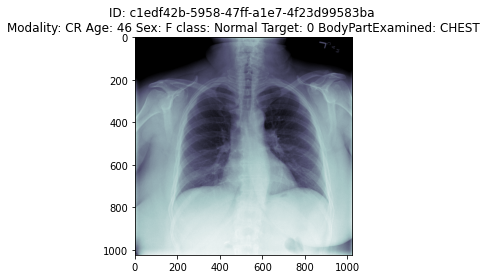

In [ ]:
MapImagesToAnnotations('c1edf42b-5958-47ff-a1e7-4f23d99583ba') #mapping image and annotations 

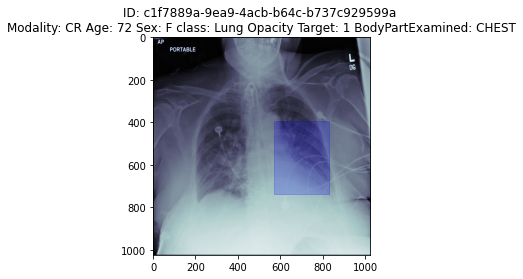

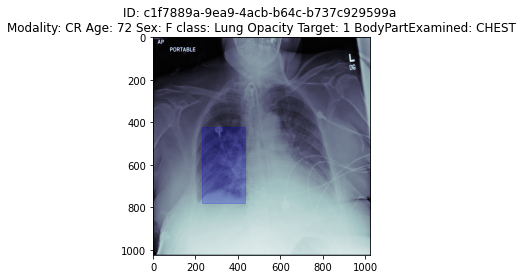

In [ ]:
MapImagesToAnnotations('c1f7889a-9ea9-4acb-b64c-b737c929599a') #mapping image and annotations

**Step 4:Preprocessing and Visualisation of different classes [4 Points]**

In [ ]:
training_data.describe(include="all").T

count unique  \
patientId       30227  26684   
x              9555.0    NaN   
y              9555.0    NaN   
width          9555.0    NaN   
height         9555.0    NaN   
Target        30227.0    NaN   
class           30227      3   
Modality        30227      1   
PatientAge    30227.0    NaN   
PatientSex      30227      2   
ViewPosition    30227      2   
path            30227  26684   

                                                            top   freq  \
patientId                  3239951b-6211-4290-b237-3d9ad17176db      4   
x                                                           NaN    NaN   
y                                                           NaN    NaN   
width                                                       NaN    NaN   
height                                                      NaN    NaN   
Target                                                      NaN    NaN   
class                              No Lung Opacity / Not Normal  11821   
Modality                                                     CR  30227   
PatientAge                                                  NaN    NaN   
PatientSex                                                    M  17216   
ViewPosition                                                 AP  15297   
path          drive/My Drive/cv capstone/stage_2_train_image...      4   

                    mean         std   min    25%    50%    75%    max  
patientId            NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x             394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y              366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width         218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height        329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target          0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class                NaN         NaN   NaN    NaN    NaN    NaN    NaN  
Modality             NaN         NaN   NaN    NaN    NaN    NaN    NaN  
PatientAge     46.797764    16.89294   1.0   34.0   49.0   59.0  155.0  
PatientSex           NaN         NaN   NaN    NaN    NaN    NaN    NaN  
ViewPosition         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
path                 NaN         NaN   NaN    NaN    NaN    NaN    NaN

**Observation:** The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier

 50% of the patiens are of aroudn 49 age , the std deviation is 16 which sugges that age is not normally distubuted

In [ ]:
training_data.PatientSex.value_counts()

M    17216
F    13011
Name: PatientSex, dtype: int64

Text(0.5, 1.0, 'class and Target for Chest Exams')

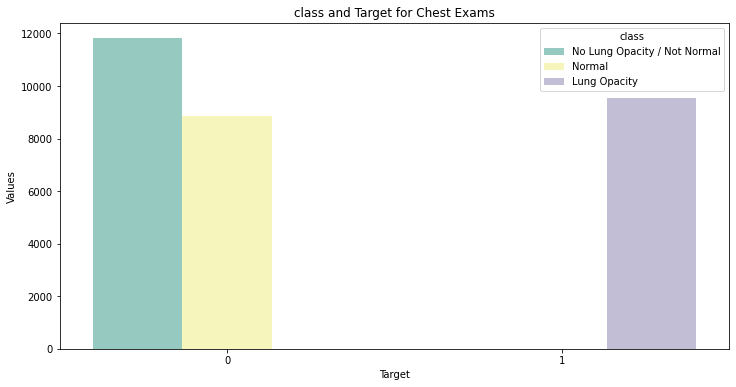

In [ ]:
## Distbution of Class Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('class and Target for Chest Exams')

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

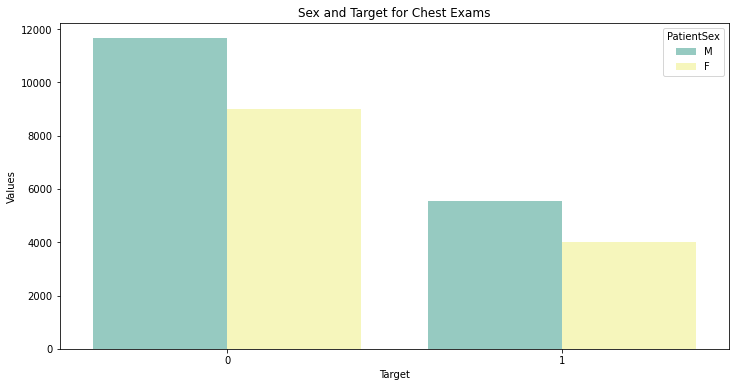

In [ ]:
## Distbution of Sex Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['PatientSex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'PatientSex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

**Observation:** The number of males in both category are higher than women 

Text(0.5, 1.0, 'Sex and class for Chest Exams')

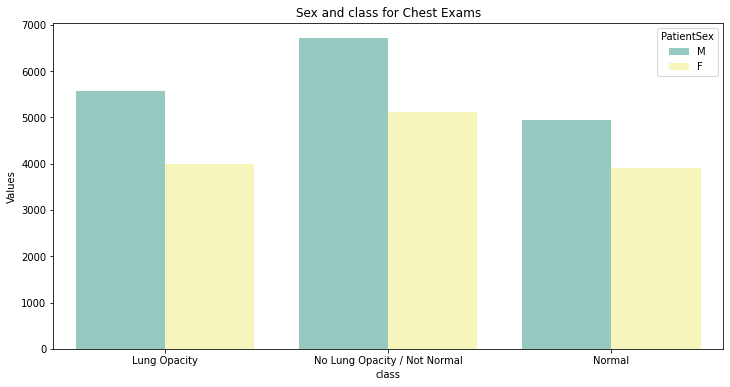

In [ ]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['PatientSex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'PatientSex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

**Observation:**  The number of males in all classes are higher than women

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


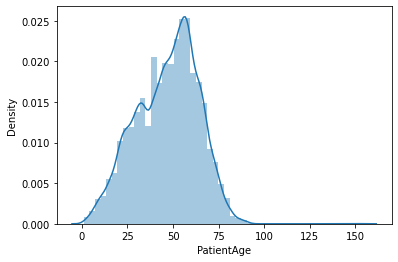

In [ ]:
# plots the distrubution of age
sns.distplot(training_data.PatientAge) 

**Observation:**  Looks like normal distubution of age

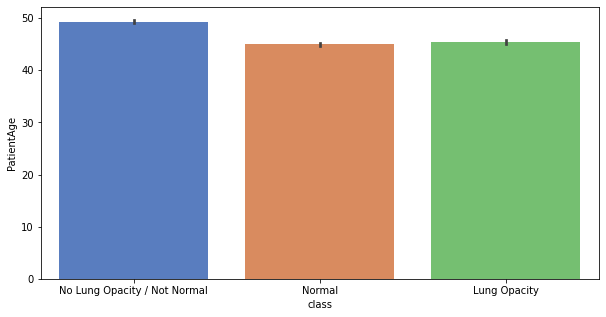

In [ ]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='PatientAge', data=training_data, palette='muted')  # barplot'

**Observation:** This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

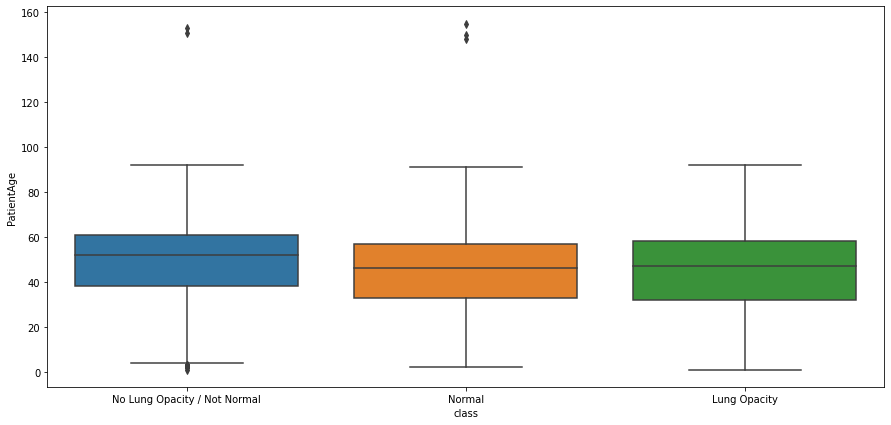

In [ ]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='PatientAge', data= training_data)
plt.show()

**Observation:** The  class which has no pneuomia has few outliers , theie age is somewhere around 155 years so we can clip the upper threshold to 100

In [ ]:
training_data['PatientAge'] = training_data['PatientAge'].clip(training_data['PatientAge'].min(), 100)

In [ ]:
temp = training_data
print('Number of patients in age category ')
temp['CategoryAge'] = pd.cut(temp['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
temp['CategoryAge'].value_counts()

Number of patients in age category 


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: CategoryAge, dtype: int64

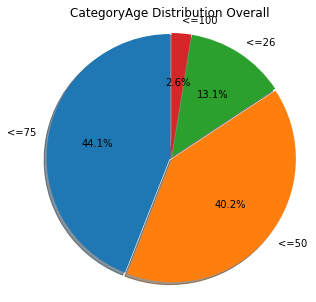

In [ ]:
label_count=temp['CategoryAge'].value_counts()
explode = (0.01,0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('CategoryAge Distribution Overall')
plt.show()

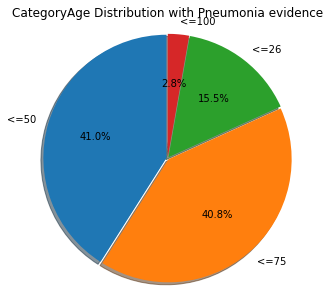

In [ ]:
label_count=temp.loc[temp['Target'] == 1,'CategoryAge'].value_counts()
explode = (0.01,0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('CategoryAge Distribution with Pneumonia evidence')
plt.show()

**Observation:**   

1.   Number of patients are highest for age group 51-75 for overall case
2.   But number of patients are highest for age group 27-50 for Target=1 case.

In [ ]:
training_data['class'].value_counts()


No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

**Observation:** 
*   There are 8851 normal cases , person with lung opactiry are 9555 and No Lung Opacity / Not Normal are 11821 
* Patients with evidence of Pneumonia are associated with Lung Opacity class and target = 1.
* Patients with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class and target = 0.

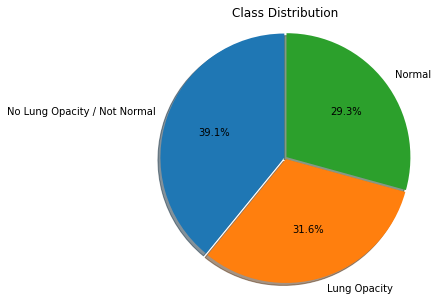

In [ ]:
label_count=training_data['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

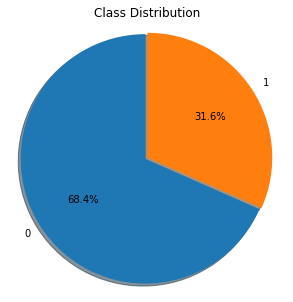

In [ ]:
label_count=training_data['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

* **Posterior/Anterior (PA)**: X-ray is taken from back part of chest. So it hits posterior part before anterior part. Patient needs to stand against X-ray machine.
* **Anterior/Posterior (AP)**: X-ray is taken from front part of chest. So it hits anterior part before posterior part. When Patient cannot stand against X-ray machine. this is taken but heart size is exaggerated.

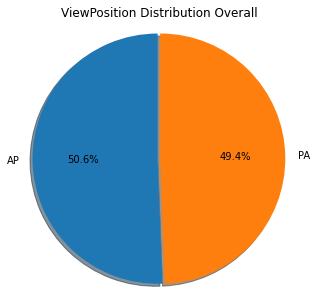

In [ ]:
label_count=training_data['ViewPosition'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('ViewPosition Distribution Overall')
plt.show()

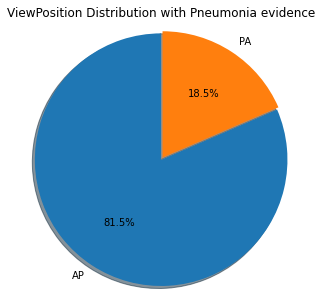

In [ ]:
label_count=training_data.loc[training_data['Target'] == 1,'ViewPosition'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('ViewPosition Distribution with Pneumonia evidence')
plt.show()

**Observation:** 
1.   ViewPosition = PA and ViewPosition = AP are almost equally distributed in the overall train data
2.   When Target=1, View position = AP dominates.

Text(0.5, 1.0, 'View Positon and Target for Chest Exams')

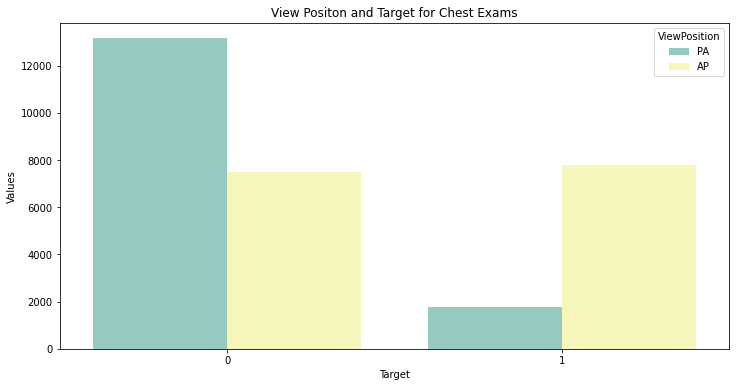

In [ ]:
# Distbution of Viewposition Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['ViewPosition'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'ViewPosition', data = data_target_class, palette = 'Set3')
plt.title('View Positon and Target for Chest Exams')

Text(0.5, 1.0, 'View Positon and class for Chest Exams')

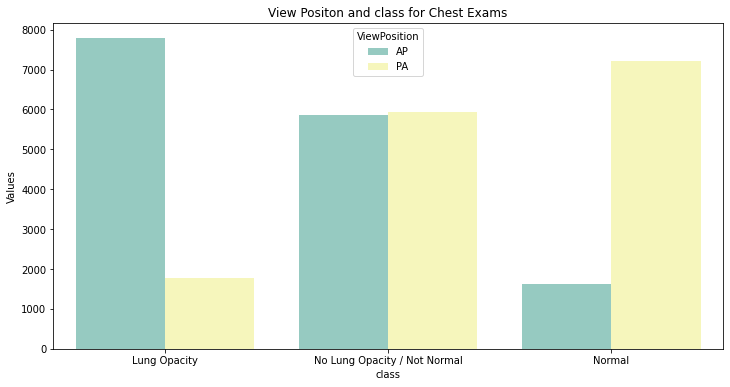

In [ ]:
# Distbution of Viewposition Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['ViewPosition'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'ViewPosition', data = data_target_class, palette = 'Set3')
plt.title('View Positon and class for Chest Exams')

In [ ]:
from matplotlib.patches import Rectangle

def plot_diagram(train_data, pnemonia_point_color, chest_image_color,text):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    plt.title("Pneumonia presence points on the chest image\n{}".format(text))
    train_data.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color=pnemonia_point_color)
    for i, train_row in train_data.iterrows():
        ax.add_patch(Rectangle(xy=(train_row['x'], train_row['y']),
            width=train_row['width'],height=train_row['height'],alpha=3.5e-3, color=chest_image_color))
    plt.show()

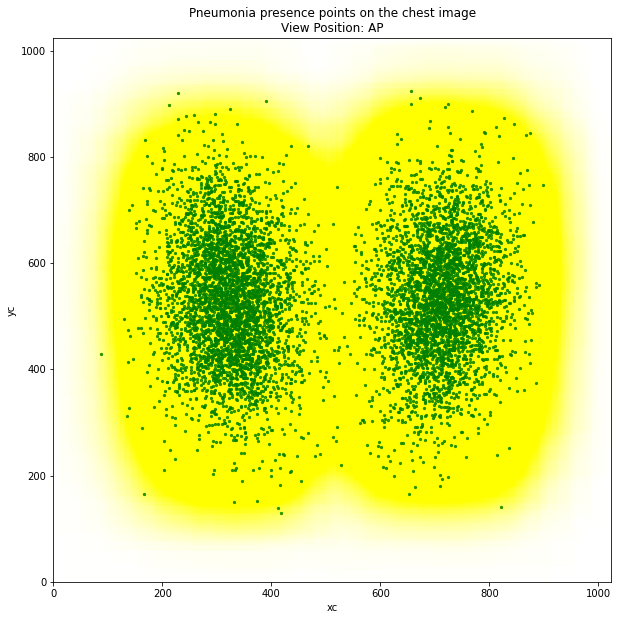

In [ ]:
temp = training_data
temp['xc'] = temp['x'] + temp['width'] / 2
temp['yc'] = temp['y'] + temp['height'] / 2
rows = (temp['ViewPosition']=='AP')  & (temp['Target']==1)
plot_diagram(temp[ rows ],'green', 'yellow', 'View Position: AP')

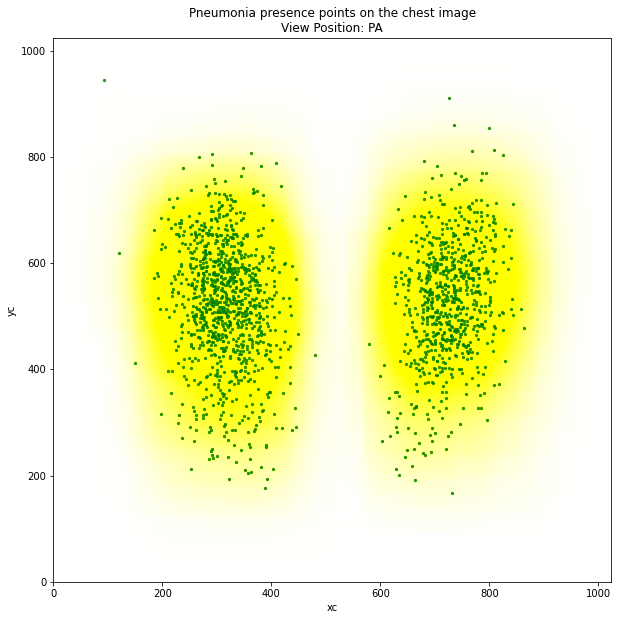

In [ ]:
rows = (temp['ViewPosition']=='PA')  & (temp['Target']==1)
plot_diagram(temp[ rows ],'green', 'yellow', 'View Position: PA')

In [ ]:
training_data.drop(['xc', 'yc','CategoryAge'], axis=1,inplace =True) #dropping unecessary columns now

In [ ]:
bounding_boxes = training_data[training_data['Target'] == 1]
bounding_boxes = bounding_boxes.groupby('patientId').size().to_frame('number_of_bounding_boxes').reset_index()
train_labels = training_data.merge(bounding_boxes, on = 'patientId', how = 'left')
print('Number of patients per bounding boxes in the dataset')
(bounding_boxes.groupby('number_of_bounding_boxes').size().to_frame('number_of_patients_per_bounding_boxes').reset_index().set_index('number_of_bounding_boxes').sort_values(by = 'number_of_bounding_boxes'))

Number of patients per bounding boxes in the dataset


number_of_patients_per_bounding_boxes
number_of_bounding_boxes                                       
1                                                          2614
2                                                          3266
3                                                           119
4                                                            13

In [ ]:
train_labels.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality  PatientAge PatientSex ViewPosition  \
0  No Lung Opacity / Not Normal       CR          51          F           PA   
1  No Lung Opacity / Not Normal       CR          48          F           PA   
2  No Lung Opacity / Not Normal       CR          19          M           AP   
3                        Normal       CR          28          M           PA   
4                  Lung Opacity       CR          32          F           AP   

                                                path  number_of_bounding_boxes  
0  drive/My Drive/cv capstone/stage_2_train_image...                       NaN  
1  drive/My Drive/cv capstone/stage_2_train_image...                       NaN  
2  drive/My Drive/cv capstone/stage_2_train_image...                       NaN  
3  drive/My Drive/cv capstone/stage_2_train_image...                       NaN  
4  drive/My Drive/cv capstone/stage_2_train_image...                       2.0

In [ ]:
train_labels[train_labels['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target  \
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   

          class Modality  PatientAge PatientSex ViewPosition  \
4  Lung Opacity       CR          32          F           AP   
5  Lung Opacity       CR          32          F           AP   

                                                path  number_of_bounding_boxes  
4  drive/My Drive/cv capstone/stage_2_train_image...                       2.0  
5  drive/My Drive/cv capstone/stage_2_train_image...                       2.0

**Observations**: Maximum patients have 2 bounding boxes while 13 patients have 4 bounding boxes.

Disturbution of Classes, there are 39% of patients with No Lung opacity , 29.3% Normal



 **Step 5: Display images with bounding box. [ 5 points ]**

In [ ]:
from matplotlib.patches import Rectangle
def boundbox(data):
  image_data = list(data.T.to_dict().values())
  f, axes = plt.subplots(2,2, figsize=(16,18))
  for index, patient_info in enumerate(image_data):
      lungs_image = patient_info['patientId']+'.dcm'
      lungs_image_data = dcm.read_file('/content/gdrive/My Drive/cv capstone/stage_2_train_images/'+lungs_image)
      axes[index//2, index%2].imshow(lungs_image_data.pixel_array, cmap=plt.cm.gray) 
      axes[index//2, index%2].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                  patient_info['patientId'],lungs_image_data.Modality, lungs_image_data.PatientAge, lungs_image_data.PatientSex, patient_info['Target'], patient_info['class']))
      matched_rows = training_data[training_data['patientId']==patient_info['patientId']]
      bounding_box = list(matched_rows.T.to_dict().values())
      for j, row in enumerate(bounding_box):
          axes[index//2, index%2].add_patch(Rectangle(xy=(row['x'], row['y']),width=row['width'],height=row['height'], color="blue",alpha = 0.1))   
  plt.show()

**X-ray images with ONE bounding box**

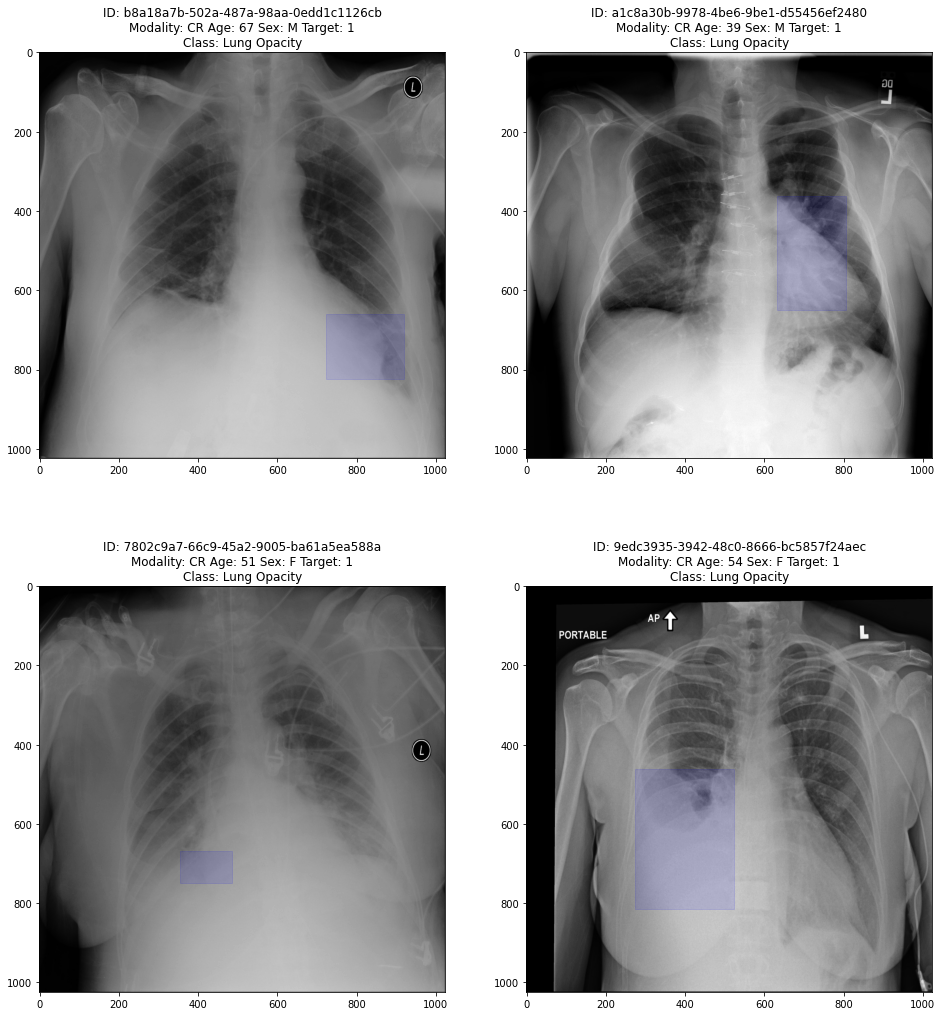

In [ ]:
data = train_labels[train_labels['number_of_bounding_boxes']==1].sample(4) 
boundbox(data)

**X-ray images with TWO bounding box**

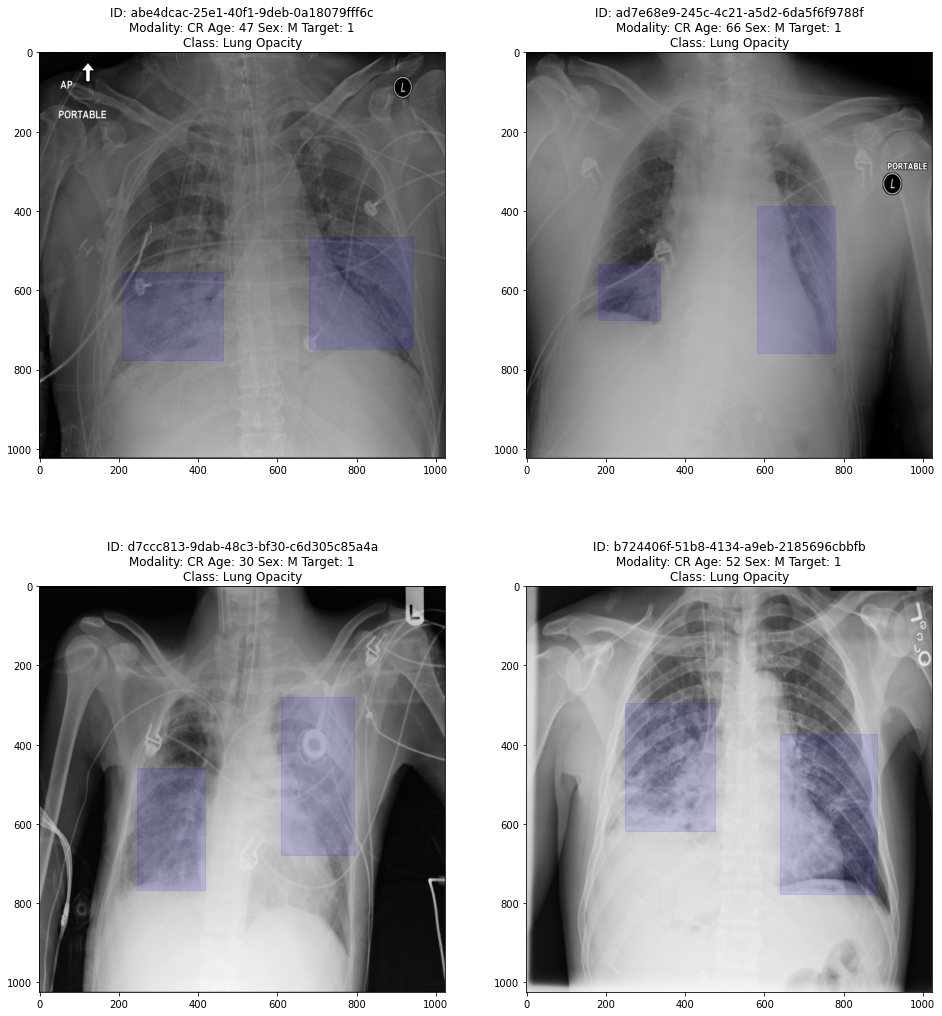

In [ ]:
data = train_labels[train_labels['number_of_bounding_boxes']==2].sample(4) 
boundbox(data)

**X-ray images with THREE bounding box**

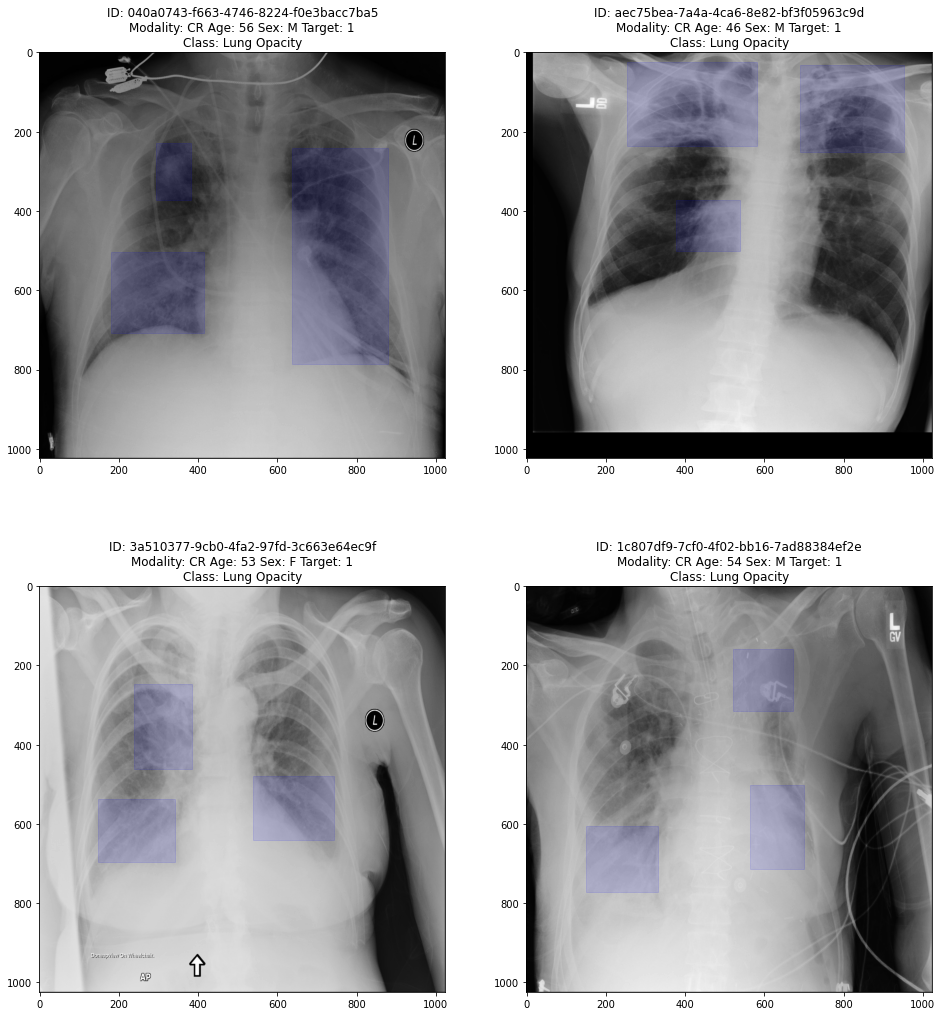

In [ ]:
data = train_labels[train_labels['number_of_bounding_boxes']==3].sample(4) 
boundbox(data)

**X-ray images with FOUR bounding box**

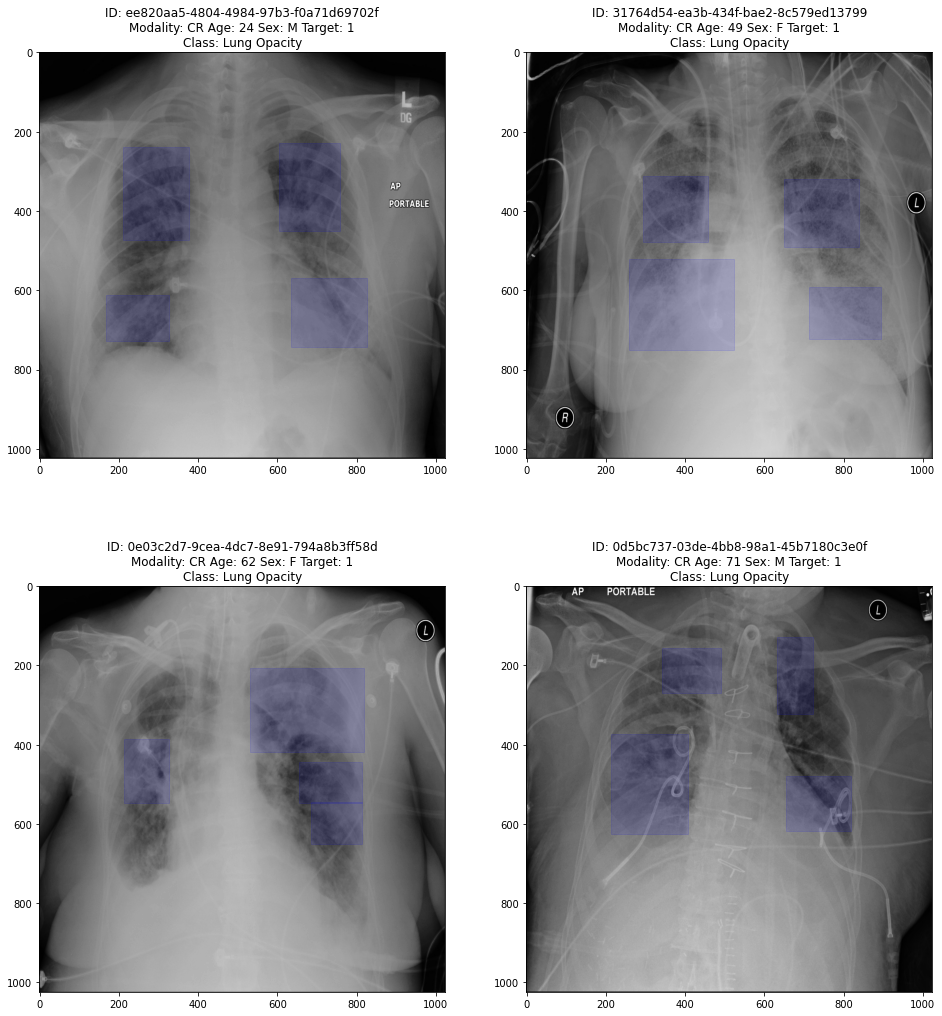

In [ ]:
data = train_labels[train_labels['number_of_bounding_boxes']==4].sample(4) 
boundbox(data)

**X-ray images with TARGET=1**

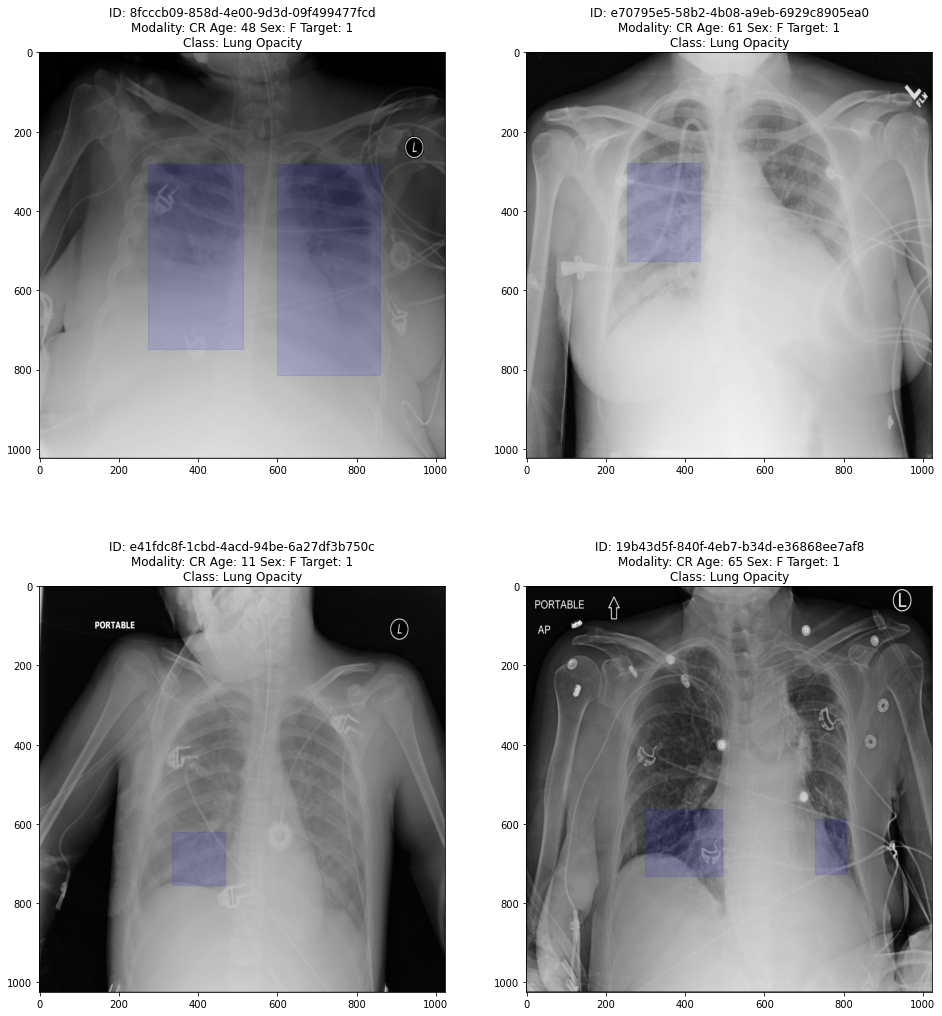

In [ ]:
data = training_data[training_data['Target']==1].sample(4) #target is 1
boundbox(data)

**X-ray images with TARGET=0 => no bounding box**

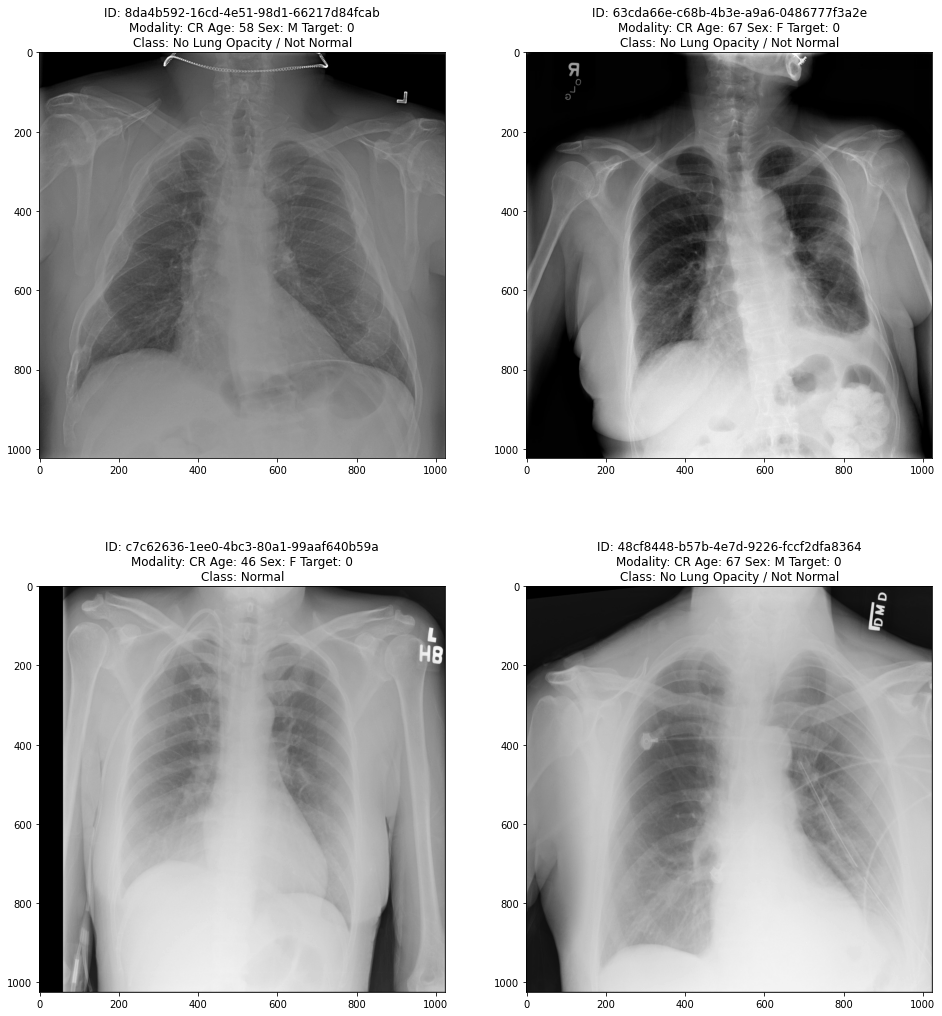

In [ ]:
data1 = training_data[training_data['Target']==0].sample(4) #target is 0
boundbox(data1)

**Step 6: Design, train and test basic CNN models for classification. [ 10 points]**

In [ ]:
training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality  PatientAge PatientSex ViewPosition  \
0  No Lung Opacity / Not Normal       CR          51          F           PA   
1  No Lung Opacity / Not Normal       CR          48          F           PA   
2  No Lung Opacity / Not Normal       CR          19          M           AP   
3                        Normal       CR          28          M           PA   
4                  Lung Opacity       CR          32          F           AP   

                                                path  
0  drive/My Drive/cv capstone/stage_2_train_image...  
1  drive/My Drive/cv capstone/stage_2_train_image...  
2  drive/My Drive/cv capstone/stage_2_train_image...  
3  drive/My Drive/cv capstone/stage_2_train_image...  
4  drive/My Drive/cv capstone/stage_2_train_image...

In [ ]:
model_trainigdata = training_data.groupby('Target', group_keys=False).apply(lambda x: x.sample(7000))

In [ ]:
model_trainigdata["Target"].value_counts()

0    7000
1    7000
Name: Target, dtype: int64

In [ ]:
from tqdm import tqdm_notebook
def resizeImage(row):
  image_data_list = [];
  target_list = [];
  for index, row in tqdm_notebook(row.iterrows()):
    patientId = row.patientId
    target = row["Target"]
    dcm_file = '/content/gdrive/My Drive/cv capstone/stage_2_train_images/' + '{}.dcm'.format(patientId)
    image_data_array = dcm.read_file(dcm_file).pixel_array

    if len(image_data_array.shape) != 3 or image_data_array.shape[2] != 3:
      image_data_array = np.stack((image_data_array,) * 3, -1)

    image_array = np.array(image_data_array).astype(np.uint8)
    image_data_array = cv2.resize(image_array, (NEW_IMAGE_SIZE, NEW_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    image_data_list.append(image_data_array)
    target_list.append(target)
  return image_data_list, target_list


In [ ]:
  imageData, targets = resizeImage(model_trainigdata)
  imageData = np.array(imageData)
  targets = np.array(targets)

<ipython-input-51-0c5e939fc742>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm_notebook(row.iterrows()):


0it [00:00, ?it/s]

In [ ]:
#create a file
picklefile = open('/content/gdrive/My Drive/cv capstone/xtrain1', 'wb')
picklefile1 = open('/content/gdrive/My Drive/cv capstone/y1', 'wb')
#pickle the dataframe
pickle.dump(imageData, picklefile)
pickle.dump(targets, picklefile1)
#close file
picklefile.close()
picklefile1.close()

In [ ]:
picklefile = open('/content/gdrive/My Drive/cv capstone/xtrain1', 'rb')
picklefile1 = open('/content/gdrive/My Drive/cv capstone/y1', 'rb')
#unpickle the dataframe
imgs= pickle.load(picklefile)
lbl= pickle.load(picklefile1)
#close file
picklefile.close()
picklefile1.close()
#print the dataframe
print(type(imgs))
print(type(lbl))

<class 'list'>
<class 'list'>


In [ ]:
imgs = np.array(imgs)
lbl = np.array(lbl)

In [ ]:
print(lbl.shape)
print(imgs.shape)

(14000,)
(14000, 128, 128, 3)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
encoded_targets = enc.fit_transform(lbl)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs, encoded_targets, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=50)

In [ ]:
NEW_IMAGE_SIZE = 128
EPOCH = 10
NUM_CLASSES = 1
NUM_CHANNELS = 3

In [ ]:
def buildBasicModel(loss='binary_crossentropy', metrics=['accuracy']):
    shape_input = (128,128,3)
    model = Sequential()
    model.add(Conv2D(filters = 32,kernel_size=(5,5), padding = 'Same', activation='relu',input_shape=shape_input))
    model.add(Conv2D(filters = 32,kernel_size=(5,5), padding = 'Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = 64,kernel_size=(4,4), padding = 'Same', activation='relu'))
    model.add(Conv2D(filters = 64,kernel_size=(4,4), padding = 'Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 128,kernel_size=(3,3), padding = 'Same', activation='relu'))
    model.add(Conv2D(filters = 128,kernel_size=(3,3), padding = 'Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.4))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = "softmax"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    return model


In [ ]:
model = buildBasicModel()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        65600     
                                                      

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val, y_val), batch_size = 32)

Epoch 1/10
307/307 [==============================] - 24s 70ms/step - loss: 0.8028 - accuracy: 0.5002 - val_loss: 0.6633 - val_accuracy: 0.4919
Epoch 2/10
307/307 [==============================] - 21s 69ms/step - loss: 0.6490 - accuracy: 0.5002 - val_loss: 0.6525 - val_accuracy: 0.4919
Epoch 3/10
307/307 [==============================] - 21s 67ms/step - loss: 0.6383 - accuracy: 0.5002 - val_loss: 0.6547 - val_accuracy: 0.4919
Epoch 4/10
307/307 [==============================] - 21s 68ms/step - loss: 0.6314 - accuracy: 0.5002 - val_loss: 0.6377 - val_accuracy: 0.4919
Epoch 5/10
307/307 [==============================] - 21s 68ms/step - loss: 0.6264 - accuracy: 0.5002 - val_loss: 0.6402 - val_accuracy: 0.4919
Epoch 6/10
307/307 [==============================] - 21s 68ms/step - loss: 0.6192 - accuracy: 0.5002 - val_loss: 0.6361 - val_accuracy: 0.4919
Epoch 7/10
307/307 [==============================] - 21s 68ms/step - loss: 0.6125 - accuracy: 0.5002 - val_loss: 0.6169 - val_accuracy:

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = 1)
print("Train loss:", loss)
print("Train_Accuracy:", accuracy)

307/307 [==============================] - 6s 21ms/step - loss: 0.6046 - accuracy: 0.5002
Train loss: 0.6045503616333008
Train_Accuracy: 0.5002040863037109


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 1)
print("Test loss:", loss)
print("Test_Accuracy:", accuracy)

66/66 [==============================] - 1s 21ms/step - loss: 0.6285 - accuracy: 0.5071
Test loss: 0.6284589767456055
Test_Accuracy: 0.5071428418159485


In [ ]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred),'\n')

66/66 [==============================] - 1s 19ms/step
Confusion Matrix:
 [[   0 1035]
 [   0 1065]] 



In [ ]:
print('Classification Report:\n',classification_report(y_test,y_pred),'\n')

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1035
           1       0.51      1.00      0.67      1065

    accuracy                           0.51      2100
   macro avg       0.25      0.50      0.34      2100
weighted avg       0.26      0.51      0.34      2100
 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Accuracy Score:\n',accuracy_score(y_test,y_pred),'\n')

Accuracy Score:
 0.5071428571428571 



In [ ]:
eval=model.evaluate(X_test,y_test)
print('Model Evaluation Loss :\n',eval[0])
print('Model Evaluation Accuracy :\n',eval[1])

66/66 [==============================] - 1s 21ms/step - loss: 0.6285 - accuracy: 0.5071
Model Evaluation Loss :
 0.6284589767456055
Model Evaluation Accuracy :
 0.5071428418159485


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input,GlobalAveragePooling2D

def build_model():
    input_shape = (NEW_IMAGE_SIZE,NEW_IMAGE_SIZE,NUM_CHANNELS)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    denseNetModel = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    densenet = Model(inputs = inputs, outputs = denseNetModel.layers[-1].output, name = 'DenseNet121')
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

In [ ]:
model = build_model()

29084464/29084464 [==============================] - 2s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseNet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
import tensorflow as tf
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr* (np.cos(np.pi*x/epochs)+1.) /2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=4, restore_best_weights=True, verbose=1, mode='auto')

In [ ]:
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 1e-4
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']
model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model.fit(X_train,y_train,
          validation_data=(X_val,y_val),
          callbacks=[learning_rate,early_stopping],
          epochs=EPOCH,
          batch_size=32)

Epoch 1/10
307/307 [==============================] - 68s 149ms/step - loss: 0.5473 - accuracy: 0.7564 - val_loss: 1.0293 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 2/10
307/307 [==============================] - 41s 134ms/step - loss: 0.4705 - accuracy: 0.7884 - val_loss: 0.5611 - val_accuracy: 0.7676 - lr: 9.9606e-04
Epoch 3/10
307/307 [==============================] - 42s 136ms/step - loss: 0.4478 - accuracy: 0.7990 - val_loss: 1.0782 - val_accuracy: 0.4919 - lr: 9.8429e-04
Epoch 4/10
307/307 [==============================] - 42s 136ms/step - loss: 0.4346 - accuracy: 0.8013 - val_loss: 0.5012 - val_accuracy: 0.7648 - lr: 9.6489e-04
Epoch 5/10
307/307 [==============================] - 41s 135ms/step - loss: 0.4259 - accuracy: 0.8049 - val_loss: 0.6473 - val_accuracy: 0.7314 - lr: 9.3815e-04
Epoch 6/10
307/307 [==============================] - 42s 138ms/step - loss: 0.4218 - accuracy: 0.8061 - val_loss: 0.4437 - val_accuracy: 0.7857 - lr: 9.0451e-04
Epoch 7/10
307/307 [============

In [ ]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred),'\n')

66/66 [==============================] - 4s 33ms/step
Confusion Matrix:
 [[844 191]
 [254 811]] 



In [ ]:
print('Classification Report:\n',classification_report(y_test,y_pred),'\n')

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79      1035
           1       0.81      0.76      0.78      1065

    accuracy                           0.79      2100
   macro avg       0.79      0.79      0.79      2100
weighted avg       0.79      0.79      0.79      2100
 



In [ ]:
print('Accuracy Score:\n',accuracy_score(y_test,y_pred),'\n')

Accuracy Score:
 0.7880952380952381 



In [ ]:
eval=model.evaluate(X_test,y_test,verbose=0)
print('Model Evaluation Loss :\n',eval[0])
print('Model Evaluation Accuracy :\n',eval[1])

Model Evaluation Loss :
 0.468567430973053
Model Evaluation Accuracy :
 0.788095235824585


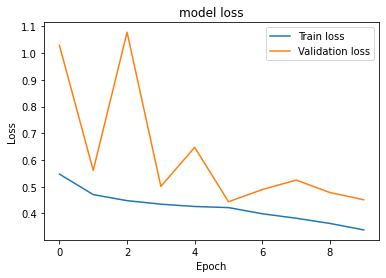

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()

66/66 [==============================] - 2s 32ms/step
Actual label: [0]
Predicted label: [0]
Model output: [0.45136756]


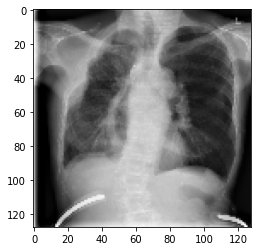

In [ ]:
plt.imshow(X_test[1], cmap ='gray')
y_pred = model.predict(X_test)
output=(model.predict(X_test) > 0.5).astype("int32")
print("Actual label:", y_test[1])
print("Predicted label:", output[1])
print("Model output:", y_pred[1])